In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from statistics import median, mean
from matplotlib import pyplot as plt
import numpy as np
import json
from tqdm import tqdm
from glob import glob
import os
import sys
sys.path.insert(0,"/study/mrphys/skunkworks/kk/mriUnet")
from fullmodel import fullModel
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.model_selection import KFold as kf
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from mriDataset import mriSliceDataset
from smoothing import GaussianSmoothing

In [2]:
# Dataset
T1path = sorted(glob('/study/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii'))
samples = [p.split('/')[6] for p in T1path]
class FullDataset(Dataset):   
    def __getitem__(self, index):
        if index<256:
            return self.xgt[:,index,:,:], self.ymask[:,index,:,:]
        elif index<512:
            index = index-256
            return self.xgt[:,:,index,:], self.ymask[:,:,index,:]
        else:
            index = index-512
            return self.xgt[:,:,:,index], self.ymask[:,:,:,index]
    def __len__(self):
        return 768

In [3]:
folds = {}
kfsplitter = kf(n_splits=5, shuffle=True, random_state=69420)
for i, (train_index, test_index) in enumerate(kfsplitter.split(samples[0:65])):
    folds[i+1] = test_index
    print(f'Fold #{i+1} : {test_index}')

Fold #1 : [ 4  7 13 16 20 21 24 31 37 40 42 56 61]
Fold #2 : [ 3  5  8 25 26 35 43 47 49 51 60 62 63]
Fold #3 : [ 6 12 17 18 19 28 32 34 36 45 48 50 58]
Fold #4 : [ 0  1  2  9 11 14 23 27 29 33 39 52 54]
Fold #5 : [10 15 22 30 38 41 44 46 53 55 57 59 64]


In [6]:
def stack(slicedArray):
    X = slicedArray[0:256]
    Y = slicedArray[256:512]
    Z = slicedArray[512:768]
    X, Y, Z = np.vstack(X).transpose(1,0,2,3), np.vstack(Y).transpose(1,2,0,3), np.vstack(Z).transpose(1,2,3,0)
    return (X+Y+Z)/3

def prediction(model, dataset):
    model.eval()
    predictions = {
        "2 mins pca (gt)":[],
        "9 mins pca (gt)":[],
        "Denoised pca (pred)":[],
        "9 minutes T1 (pred)":[],
        "Denoised T1 (pred)":[],
        "T1 (gt)":[],
        "mask (gt)":[],
        "Denoised mask (pred)":[],
        "9 minutes mask (pred)":[],
    }
    for i, data in tqdm(enumerate(dataset)):
        xgt, ymask = data
        x = torch.tensor(xgt).unsqueeze(0)[:,0:10].to(model.device)
        gt = torch.tensor(xgt).unsqueeze(0)[:,10:20].to(model.device)
        y = torch.tensor(ymask).unsqueeze(0)[:,0:1].to(model.device)
        mask = torch.tensor(ymask).unsqueeze(0)[:,1:2].to(model.device)
        # x - 2 mins pca
        # gt - 9 mins pca
        # y - t1 mapping
        # mask - 0,1,2,3 -> bkg,csf,wm,gm
        with torch.no_grad():
            preds, losses, loss = model(x, gt, y, mask.clone())
            denoised_x, y_pred_denoised, y_pred_gt, denoised_mask_logit, gt_mask_logit = preds
            addToDict = {
                "2 mins pca (gt)":x.cpu().numpy(),
                "9 mins pca (gt)":gt.cpu().numpy(),
                "Denoised pca (pred)":denoised_x.cpu().numpy(),
                "9 minutes T1 (pred)":y_pred_gt.cpu().numpy(),
                "Denoised T1 (pred)":y_pred_denoised.cpu().numpy(),
                "T1 (gt)":y.cpu().numpy(),
                "mask (gt)":mask.cpu().numpy(),
                "Denoised mask (pred)":torch.sigmoid(denoised_mask_logit).cpu().numpy(),
                "9 minutes mask (pred)":torch.sigmoid(gt_mask_logit).cpu().numpy(),
            }
            for key in addToDict.keys():
                predictions[key].append(addToDict[key])
                
    for key in predictions.keys():
        predictions[key] = stack(predictions[key])
                   
    return predictions

In [6]:
fold = 1
gpu_id = 'cuda'
name = f"fullModel_{fold}"

model = fullModel().to(gpu_id)
model.load_state_dict(torch.load(f'/study/mrphys/skunkworks/kk/outputs/{name}/weights/{name}_BEST.pth', map_location=gpu_id))
model.device = gpu_id

index = folds[fold][0]
with open(f'/scratch/mrphys/pickled/fullDataset_{index}.pickle', 'rb') as f:
    dataset = pickle.load(f)

In [7]:
for fold in folds.keys():
    gpu_id = 'cuda'
    name = f"fullModel_{fold}"
    model = fullModel().to(gpu_id)
    model.load_state_dict(torch.load(f'/study/mrphys/skunkworks/kk/outputs/{name}/weights/{name}_BEST.pth', map_location=gpu_id))
    model.device = gpu_id

    for index in folds[fold]:
        with open(f'/scratch/mrphys/pickled/fullDataset_{index}.pickle', 'rb') as f:
            dataset = pickle.load(f)
            predictions = prediction(model, dataset)
            # unpack
            acc = predictions["2 mins pca (gt)"]
            full = predictions["9 mins pca (gt)"]
            denoised = predictions["Denoised pca (pred)"]
            T1_full = predictions["9 minutes T1 (pred)"]
            T1_denoised = predictions["Denoised T1 (pred)"]
            T1_gt = predictions["T1 (gt)"]
            mask = predictions["mask (gt)"]
            mask_denoised = predictions["Denoised mask (pred)"]
            mask_full = predictions["9 minutes mask (pred)"]
            np.save(f'/study/mrphys/skunkworks/kk/T1/T1_2min_{str(index).zfill(2)}.npy', T1_full)

768it [01:33,  8.18it/s]
768it [01:32,  8.28it/s]
768it [01:33,  8.25it/s]
768it [01:33,  8.17it/s]
768it [01:32,  8.33it/s]
768it [01:36,  7.96it/s]
768it [01:33,  8.21it/s]
768it [01:35,  8.01it/s]
768it [01:34,  8.10it/s]
768it [01:37,  7.92it/s]
768it [01:33,  8.22it/s]
768it [01:35,  8.07it/s]
768it [01:33,  8.19it/s]
686it [01:21,  8.39it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

768it [01:33,  8.21it/s]
551it [01:06,  8.36it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs

In [ ]:
for fold in folds.keys():
    gpu_id = 'cuda'
    name = f"fullModel_{fold}"
    model = fullModel().to(gpu_id)
    model.load_state_dict(torch.load(f'/study/mrphys/skunkworks/kk/outputs/{name}/weights/{name}_BEST.pth', map_location=gpu_id))
    model.device = gpu_id

    for index in folds[fold]:
        with open(f'/scratch/mrphys/pickled/fullDataset_{index}.pickle', 'rb') as f:
            dataset = pickle.load(f)
            predictions = prediction(model, dataset)
            # unpack
            acc = predictions["2 mins pca (gt)"]
            full = predictions["9 mins pca (gt)"]
            denoised = predictions["Denoised pca (pred)"]
            T1_full = predictions["9 minutes T1 (pred)"]
            T1_denoised = predictions["Denoised T1 (pred)"]
            T1_gt = predictions["T1 (gt)"]
            mask = predictions["mask (gt)"]
            mask_denoised = predictions["Denoised mask (pred)"]
            mask_full = predictions["9 minutes mask (pred)"]
            np.save(f'/study/mrphys/skunkworks/kk/pred/denoised_{index}.npy', denoised)
            
allImages = sorted(glob('/study/mrphys/skunkworks/kk/pred/denoised_*.npy', recursive=True))
try:
    os.mkdir('/scratch/mrphys/denoised')
except:
    pass

768it [01:34,  8.14it/s]
768it [01:34,  8.10it/s]
768it [01:35,  8.05it/s]
768it [01:30,  8.53it/s]
768it [01:31,  8.38it/s]
646it [01:15,  8.37it/s]

In [46]:
predictions = prediction(model, dataset)

768it [00:55, 13.75it/s]


In [47]:
# unpack
acc = predictions["2 mins pca (gt)"]
full = predictions["9 mins pca (gt)"]
denoised = predictions["Denoised pca (pred)"]
T1_full = predictions["9 minutes T1 (pred)"]
T1_denoised = predictions["Denoised T1 (pred)"]
T1_gt = predictions["T1 (gt)"]
mask = predictions["mask (gt)"]
mask_denoised = predictions["Denoised mask (pred)"]
mask_full = predictions["9 minutes mask (pred)"]

<Figure size 640x480 with 0 Axes>

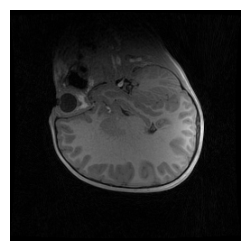

<Figure size 640x480 with 0 Axes>

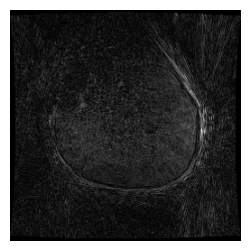

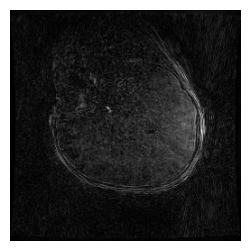

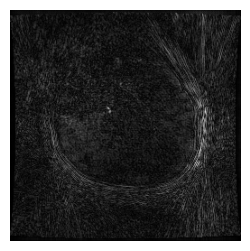

In [61]:
n = 100
c = 0

plt.gray()
plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(np.abs(full[c,:,n,:]))
plt.show()

plt.gray()
plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(np.abs((full-acc)[c,:,n,:]))
plt.show()

plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(np.abs((full-denoised)[c,:,n,:]))
plt.show()

plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(np.abs((acc-denoised)[c,:,n,:]))
plt.show()

In [49]:
# mask-scaling
T1_denoised_scaled = T1_denoised*mask_denoised
T1_full_scaled = T1_full*mask_full

In [50]:
#smoothening
smoother = GaussianSmoothing(1, 10, 0.2, 3).to(gpu_id)
def smoothen(pred, mask):
    e = np.copy(pred)
    e[mask==0] = 0.0
    e = smoother(torch.tensor(e).float().to(gpu_id))
    return e.cpu().numpy()
T1_full_s = smoothen(T1_full_scaled, mask)
T1_denoised_s = smoothen(T1_denoised_scaled, mask)
T1_gt_s = smoothen(T1_gt, mask)

In [51]:
# difference
denoised_diff = full - denoised
T1_diff_full = T1_gt_s - T1_full_s
T1_diff_denoised = T1_gt_s - T1_denoised_s

In [52]:
# percentage diff
T1_diff_full_percentage = T1_diff_full / (T1_gt_s+(mask==0).astype(int))
T1_diff_denoised_percentage = T1_diff_denoised / (T1_gt_s+(mask==0).astype(int))

In [53]:
def meanPMsd(src):
    mean = str(round(np.average(src),2))
    sd = str(round(np.std(src),2))
    return f"{mean} \u00B1 {sd}"

In [54]:
print('Denoised Scan T1 Prediction')
print(f'Region\tT1 difference\tT1 % diff\tT1 abs diff\tT1 % abs diff')
cond = mask!=0
print(f'Brain\t{meanPMsd(T1_diff_denoised[cond]*1000)}\t{meanPMsd(T1_diff_denoised_percentage[cond]*100)}\t{meanPMsd(np.abs(T1_diff_denoised[cond]*1000))}\t{meanPMsd(np.abs(T1_diff_denoised_percentage[cond]*100))}')
cond = mask==2
print(f'GM\t{meanPMsd(T1_diff_denoised[cond]*1000)}\t{meanPMsd(T1_diff_denoised_percentage[cond]*100)}\t{meanPMsd(np.abs(T1_diff_denoised[cond]*1000))}\t{meanPMsd(np.abs(T1_diff_denoised_percentage[cond]*100))}')
cond = mask==3
print(f'WM\t{meanPMsd(T1_diff_denoised[cond]*1000)}\t{meanPMsd(T1_diff_denoised_percentage[cond]*100)}\t{meanPMsd(np.abs(T1_diff_denoised[cond]*1000))}\t{meanPMsd(np.abs(T1_diff_denoised_percentage[cond]*100))}')
print('\nFull Scan T1 Prediction')
print(f'Region\tT1 difference\tT1 % diff\tT1 abs diff\tT1 % abs diff')
cond = mask!=0
print(f'Brain\t{meanPMsd(T1_diff_full[cond]*1000)}\t{meanPMsd(T1_diff_full_percentage[cond]*100)}\t{meanPMsd(np.abs(T1_diff_full[cond]*1000))}\t{meanPMsd(np.abs(T1_diff_full_percentage[cond]*100))}')
cond = mask==2
print(f'GM\t{meanPMsd(T1_diff_full[cond]*1000)}\t{meanPMsd(T1_diff_full_percentage[cond]*100)}\t{meanPMsd(np.abs(T1_diff_full[cond]*1000))}\t{meanPMsd(np.abs(T1_diff_full_percentage[cond]*100))}')
cond = mask==3
print(f'WM\t{meanPMsd(T1_diff_full[cond]*1000)}\t{meanPMsd(T1_diff_full_percentage[cond]*100)}\t{meanPMsd(np.abs(T1_diff_full[cond]*1000))}\t{meanPMsd(np.abs(T1_diff_full_percentage[cond]*100))}')

Denoised Scan T1 Prediction
Region	T1 difference	T1 % diff	T1 abs diff	T1 % abs diff
Brain	71.04 ± 155.16	4.77 ± 9.53	98.64 ± 139.26	6.49 ± 8.45
GM	86.96 ± 135.23	5.54 ± 9.32	109.29 ± 117.92	6.95 ± 8.32
WM	26.91 ± 50.57	2.57 ± 4.51	41.07 ± 39.94	3.96 ± 3.36

Full Scan T1 Prediction
Region	T1 difference	T1 % diff	T1 abs diff	T1 % abs diff
Brain	79.58 ± 117.09	4.85 ± 7.21	84.68 ± 113.45	5.34 ± 6.86
GM	99.19 ± 95.27	6.16 ± 6.54	101.8 ± 92.48	6.34 ± 6.37
WM	14.58 ± 33.85	1.2 ± 2.92	24.16 ± 27.84	2.27 ± 2.18


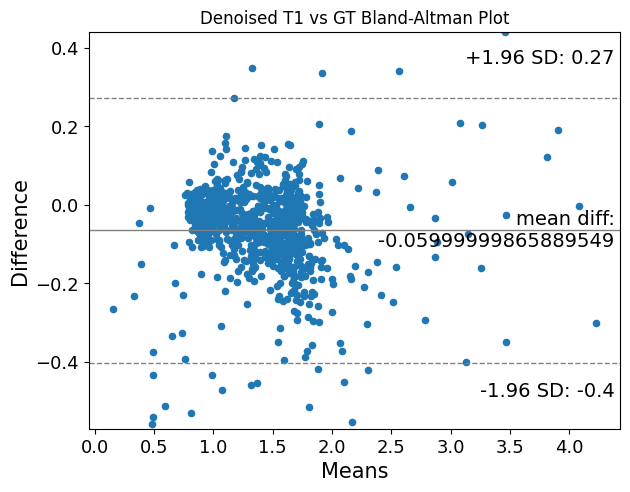

In [55]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

import pandas as pd

values = T1_denoised_s[mask!=0]
groundtruth = T1_gt_s[mask!=0]
i = np.random.choice(np.arange(len(values)),1000,replace=False)

df = pd.DataFrame({'A': list(values[i]),
                   'B': list(groundtruth[i])})

#create Bland-Altman plot                  
fig, ax = plt.subplots(1)
sm.graphics.mean_diff_plot(df.A, df.B, ax = ax)

#display Bland-Altman plot
plt.title("Denoised T1 vs GT Bland-Altman Plot")
plt.show()

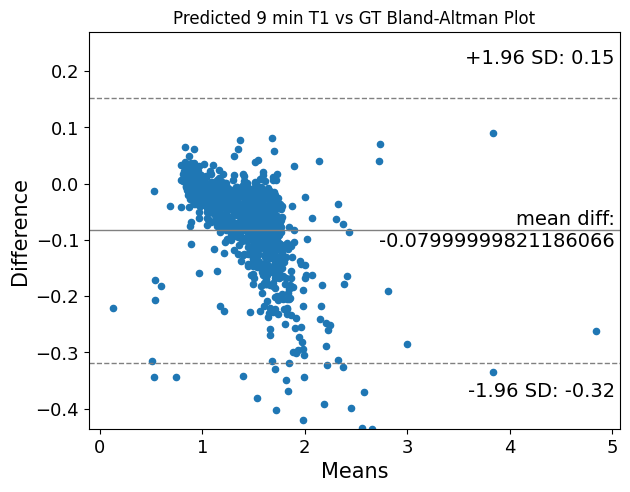

In [56]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

import pandas as pd

values = T1_full_s[mask!=0]
groundtruth = T1_gt_s[mask!=0]
i = np.random.choice(np.arange(len(values)),1000,replace=False)

df = pd.DataFrame({'A': list(values[i]),
                   'B': list(groundtruth[i])})

#create Bland-Altman plot                  
fig, ax = plt.subplots(1)
sm.graphics.mean_diff_plot(df.A, df.B, ax = ax)

#display Bland-Altman plot
plt.title("Predicted 9 min T1 vs GT Bland-Altman Plot")
plt.show()

In [57]:
mask_pred = mask_denoised>0.5
mask_true = mask!=0

In [58]:
import sklearn
sklearn.metrics.f1_score(mask_pred.reshape(-1), mask_true.reshape(-1))

0.9830342190354519

In [83]:
num_p = 0
for p in model.denoiser.parameters():
    num_p += p.reshape(-1).shape[0]

In [84]:
num_p

236891